# Tutorial on the BTCV dataset


In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.3.dev2329
Numpy version: 1.21.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c82c65a288e396f8f7d059e82373edb1814b20be
MONAI __file__: /u/08/hakkini2/unix/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.1
TorchVision version: 0.15.2+cu117
tqdm version: 4.59.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#in

## Setup data directory

In [3]:
os.environ["MONAI_DATA_DIRECTORY"] = "~/ComputerVision/SwinUNETR/tutorial-BTCV/"

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


~/ComputerVision/SwinUNETR/tutorial-BTCV/
~/ComputerVision/SwinUNETR/tutorial-BTCV/best_metric_model.pth


## Setup transforms for training and validation

In [3]:
num_samples = 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)


/u/08/hakkini2/unix/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


## Data loading

In [4]:
data_dir = "data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


## Check data shape and visualize

image shape: torch.Size([1, 314, 215, 234]), label shape: torch.Size([1, 314, 215, 234])


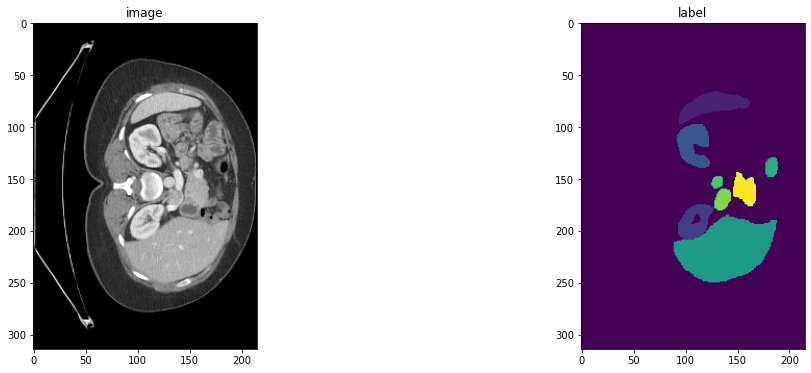

In [5]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

## Create Swin UNETR Model

Create Swin UNETR model for 14-class multi-organ segmentation (BTCV challenge).

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,    # gradient checkpointing (=re-calculate some operations to save memory)
).to(device)

## Initialize Swin UNETR encoder from self-supervised pre-trained weights

In [7]:
weight = torch.load("./model_swinvit.pt")
model.load_from(weights=weight)
del weight
print("Using pretrained self-supervied Swin UNETR backbone weights !")

Using pretrained self-supervied Swin UNETR backbone weights !


## Optimizer and loss function

In [8]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

## Training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 1, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    print("\n validation done! \n")
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [10]:
max_iterations = 30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

Training (X / X Steps) (loss=X.X):   0%|          | 0/24 [00:00<?, ?it/s]

Training (500 / 30000 Steps) (loss=1.48704):  83%|████████▎ | 20/24 [00:19<00:03,  1.05it/s]/u/08/hakkini2/unix/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Training (500 / 30000 Steps) (loss=1.48704):  88%|████████▊ | 21/24 [00:56<00:35, 12.00s/it]


 validation done! 

Model Was Saved ! Current Best Avg. Dice: 0.12538284063339233 Current Avg. Dice: 0.12538284063339233


Validate (984 / 10 Steps): 100%|██████████| 6/6 [00:36<00:00,  6.11s/it]:16<00:07,  1.06it/s]



 validation done! 



Training (1000 / 30000 Steps) (loss=1.20235):  71%|███████   | 17/24 [00:53<01:24, 12.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1966463178396225 Current Avg. Dice: 0.1966463178396225


Validate (1488 / 10 Steps): 100%|██████████| 6/6 [00:36<00:00,  6.02s/it]12<00:11,  1.05it/s]



 validation done! 



Training (1500 / 30000 Steps) (loss=1.08767):  54%|█████▍    | 13/24 [00:48<02:11, 11.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.28352463245391846 Current Avg. Dice: 0.28352463245391846


Validate (1992 / 10 Steps): 100%|██████████| 6/6 [00:37<00:00,  6.24s/it]8<00:15,  1.05it/s]



 validation done! 



Training (2000 / 30000 Steps) (loss=0.99761):  38%|███▊      | 9/24 [00:46<03:11, 12.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.38243070244789124 Current Avg. Dice: 0.38243070244789124


Validate (2496 / 10 Steps): 100%|██████████| 6/6 [00:38<00:00,  6.34s/it]4<00:18,  1.06it/s]



 validation done! 



Training (2500 / 30000 Steps) (loss=0.93282):  21%|██        | 5/24 [00:43<04:40, 14.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.48770764470100403 Current Avg. Dice: 0.48770764470100403


Training (2754 / 30000 Steps) (loss=0.91774):  79%|███████▉  | 19/24 [00:18<00:04,  1.01it/s]


KeyboardInterrupt: 